## 第 14 回　遺伝子データ解析
## シングルセル解析 3
### クラスタリング
- 高次元データを低次元の連続値に次元削減するのではなく、データ点全体を互いに類似したいくつかのクラスタに分割する分析手法がクラスタリング。
  - 階層的クラスタリング
  - k-means クラスタリング
  - k 近傍グラフに基づくアプローチ 
---
---

### ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### データの読込

In [2]:
# 遺伝子 ID と遺伝子のシンボルが記述された genes.tsv をデータフレーム genes に代入
genes = pd.read_csv('data/genes.tsv', sep='\t', index_col=0)

# 正規化テーブルから highly variable genes の項目のみ抽出した df_HVGs.gz をデータフレーム df_HVGs に代入
df_HVGs = pd.read_pickle('data/df_HVGs.gz')

# df_HVGs.gz の標準化後のデータ df_scaled.gz をデータフレーム df_scaled に代入
df_scaled = pd.read_pickle('data/df_scaled.gz')

#
#sample_labels = ['Days0-3', 'Days6-9', 'Days12-15', 'Days18-21', 'Days24-27']
label_to_colors = {
    'Days0-3': 'red',
    'Days6-9': 'orange',
    'Days12-15': 'yellow',
    'Days18-21': 'green',
    'Days24-27': 'blue'}

### ライブラリのインポートとデータの読込

---
### 階層的クラスタリング

- **階層的クラスタリング**は、ボトムアップ型のクラスタリング手法の一つ
  - データ点全体の中からもっとも距離が近い（類似性が高い）ペアを探して併合
  - その次に距離が近いペアを探して併合
  - ...
- 結果は**デンドログラム**として得られる  

<img src="figs/cls.jpg" width="300px">

#### 距離
- **ユークリッド距離**：幾何学的な距離指標の一つ
  - $n$ 次元空間上の点 $p$, $q$ のユークリッド距離 $d(p.q)$
  $$
  d(p,q)=\sqrt{\sum_{i=1}^n(p_i-q_i)^2}
  $$
- **Jaccard 距離**：集合論的な距離指標の一つ
  - $P$ をある細胞で発現している遺伝子の集合、$Q$ を別の細胞で発現している遺伝子の集合
  $$
  d(P,Q)=\frac{|P\cup Q|-|P\cap Q|}{|P\cup Q|}
  $$
    - $|P\cup Q|$：$P$ と $Q$ の和集合の要素数（少なくともどちらかに含まれる遺伝子の数）
    - $|P\cap Q|$：$P$ と $Q$ の積集合の要素数（$P$ と $Q$ で共通している遺伝子の数）
- 距離の選択は、データの性質や解析の目的によっても変わり、どんなケースにも通用する処方箋はない

#### sipy.spatial.distance に含まれる距離関数
- Seaborn ライブラリの clusteringmap() 関数による階層的クラスタリングで、内部的に呼び出される関数

In [3]:
# 距離関数のチェック

scipy.spatial.distance._METRICS_NAMES

['braycurtis',
 'canberra',
 'chebyshev',
 'cityblock',
 'correlation',
 'cosine',
 'dice',
 'euclidean',
 'hamming',
 'jaccard',
 'jensenshannon',
 'kulczynski1',
 'mahalanobis',
 'minkowski',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'yule']

#### クラスタ間の距離の測り方
- single-linkage：クラスタ間の距離を、それぞれのクラスタ内の**もっとも近い**データ点間の距離とする
- complete-linkage：クラスタ間の距離を、それぞれのクラスタ内の**もっとも遠い**データ点間の距離とする
- **UPGMA**（unweighted pair group method with arithmetic mean）：クラスタに含まれるデータ点間の距離の平均値をクラスタ間の距離とする
- **ウォード法**（Ward's method）：2 つのクラスタを 1 つのクラスタに統合した際のデータの広がり（クラスタ内分散、データ点間のユークリッド距離の平方和）の増加分を距離として、それが最小となるようにクラスタを統合。外れ値に強く、精度の良いクラスタができる傾向にある

<img src="figs/cls_method.jpg" width="400px">

#### scipy.cluster.hierarchy に含まれる手法
- Seaborn ライブラリの clusteringmap() 関数による階層的クラスタリングで、内部的に呼び出される関数

In [4]:
# 階層的クラスタリングの手法一覧

list(scipy.cluster.hierarchy._LINKAGE_METHODS)

['single', 'complete', 'average', 'centroid', 'median', 'ward', 'weighted']

---
### 実例

#### 細胞をランダムに 100 個、遺伝子は発現量の細胞間分散が大きい 100 個を抜き出して解析する。

#### 発現量の細胞間分散が大きい遺伝子 100 個を抜き出す

In [5]:
# df_HVGs は発現量変動の大きい 2000 個の遺伝子をまとめた DataFrame だった
# そこからさらに var()で分散を計算して降順にソートし，上から 100 個の遺伝子IDを取り出す

top100_gene_index = df_HVGs.var(axis=1).sort_values(ascending=False).index[:100]
df_for_hclust = df_HVGs.loc[top100_gene_index, :]
df_for_hclust

Days0-3                                    \
                AAACCGTGGCTACA-1 AAACGCTGTAGCGT-1 AAAGATCTGGTACT-1   
GeneID                                                               
ENSG00000011465         0.000000         0.000000         0.000000   
ENSG00000111057         0.000000         2.432566         2.311942   
ENSG00000139329         0.000000         0.000000         0.000000   
ENSG00000170421         0.000000         1.171248         1.185860   
ENSG00000134333         3.602394         3.010233         3.419546   
...                          ...              ...              ...   
ENSG00000106211         0.000000         1.171248         1.713258   
ENSG00000144381         2.189440         2.365190         3.011840   
ENSG00000102265         0.000000         1.549693         0.000000   
ENSG00000123416         3.358838         3.600492         3.762590   
ENSG00000142871         1.602435         0.000000         0.000000   

                                                                    \
                AAAGATCTTCCTTA-1 AAAGTTTGAGCTCA-1 AACAATACGACAAA-1   
GeneID                                                               
ENSG00000011465         0.000000         0.000000         0.000000   
ENSG00000111057         3.020306         2.071184         2.092767   
ENSG00000139329         0.000000         0.000000         0.000000   
ENSG00000170421         0.916216         1.281025         0.000000   
ENSG00000134333         2.047584         2.860414         3.645801   
...                          ...              ...              ...   
ENSG00000106211         0.916216         1.281025         1.021310   
ENSG00000144381         2.620923         1.955498         2.456248   
ENSG00000102265         0.559562         0.000000         0.000000   
ENSG00000123416         3.707334         3.387897         3.548461   
ENSG00000142871         0.000000         1.005602         0.000000   

                                                                    \
                AACAATACGCTTCC-1 AACGGTTGACGCTA-1 AACGTTCTTGACCA-1   
GeneID                                                               
ENSG00000011465         0.000000         0.000000         0.000000   
ENSG00000111057         1.152292         2.294935         2.319590   
ENSG00000139329         0.000000         0.000000         0.000000   
ENSG00000170421         1.673516         1.849128         0.000000   
ENSG00000134333         2.268176         2.294935         3.744120   
...                          ...              ...              ...   
ENSG00000106211         1.152292         1.849128         0.927660   
ENSG00000144381         2.638531         2.602194         2.582387   
ENSG00000102265         1.152292         1.024161         0.927660   
ENSG00000123416         3.573666         3.444924         4.104539   
ENSG00000142871         0.000000         0.000000         0.927660   

                                  ...        Days24-27                   \
                AACTACCTTTACTC-1  ... TTGCTAACTCGTTT-1 TTGGTACTCGATAC-1   
GeneID                            ...                                     
ENSG00000011465         0.000000  ...         1.245666         3.883083   
ENSG00000111057         0.967790  ...         1.245666         0.000000   
ENSG00000139329         0.000000  ...         0.000000         3.301950   
ENSG00000170421         1.774335  ...         0.000000         0.000000   
ENSG00000134333         0.000000  ...         3.147476         0.000000   
...                          ...  ...              ...              ...   
ENSG00000106211         1.450264  ...         0.000000         1.750481   
ENSG00000144381         1.774335  ...         2.131292         2.096306   
ENSG00000102265         0.000000  ...         0.000000         1.750481   
ENSG00000123416         3.843731  ...         4.473165         4.704288   
ENSG00000142871         0.000000  ...         0.000000         1.217487   

                               

#### 細胞をランダムに 100 個抜き出す

In [6]:
# さらにランダムな細胞100個を抜き出す
# Numpy の random.choice()関数を使って，列のサイズからランダムな数を 100 個非復元抽出する

random_cell_index = np.random.choice(
    len(df_for_hclust.columns),
    100,
    replace=False)

df_for_hclust = df_for_hclust.iloc[:, random_cell_index]
df_for_hclust

Days18-21        Days24-27                   \
                AGTTCTACACTCAG-1 AGTTATGAGGTTAC-1 GGAGCAGACTCCAC-1   
GeneID                                                               
ENSG00000011465         0.000000         0.000000         1.810332   
ENSG00000111057         2.605588         0.000000         0.000000   
ENSG00000139329         0.000000         2.552123         3.065720   
ENSG00000170421         2.986125         1.934005         0.000000   
ENSG00000134333         0.000000         0.000000         3.953640   
...                          ...              ...              ...   
ENSG00000106211         0.000000         0.000000         2.418139   
ENSG00000144381         2.342228         2.552123         2.418139   
ENSG00000102265         1.419438         1.934005         0.000000   
ENSG00000123416         2.986125         1.934005         4.211567   
ENSG00000142871         1.419438         2.552123         3.065720   

                       Days12-15        Days24-27        Days18-21  \
                GTTAAAACCTCGAA-1 CGCTAAGATTTGGG-1 AATCTAGAATGGTC-1   
GeneID                                                               
ENSG00000011465         0.000000         1.446403         0.000000   
ENSG00000111057         1.744025         0.000000         2.319590   
ENSG00000139329         0.000000         0.000000         0.000000   
ENSG00000170421         0.000000         1.446403         1.400485   
ENSG00000134333         3.923227         2.847177         2.582387   
...                          ...              ...              ...   
ENSG00000106211         0.000000         2.014318         1.400485   
ENSG00000144381         2.345706         0.000000         1.400485   
ENSG00000102265         1.744025         0.000000         0.000000   
ENSG00000123416         2.345706         3.766338         4.653424   
ENSG00000142871         1.211989         0.000000         0.000000   

                         Days0-3                           Days6-9  \
                AGAATACTAACCGT-1 TATCCAACCTCGCT-1 TGGATGTGTCCGTC-1   
GeneID                                                               
ENSG00000011465         0.000000         0.000000         0.000000   
ENSG00000111057         0.000000         0.735424         2.199004   
ENSG00000139329         0.000000         0.000000         0.000000   
ENSG00000170421         0.000000         1.449057         0.000000   
ENSG00000134333         2.634519         2.641653         0.000000   
...                          ...              ...              ...   
ENSG00000106211         1.670007         0.000000         0.000000   
ENSG00000144381         2.264302         2.377442         0.000000   
ENSG00000102265         0.000000         0.000000         1.611040   
ENSG00000123416         4.308211         3.744359         3.220798   
ENSG00000142871         0.000000         0.000000         0.000000   

                       Days24-27  ...          Days6-9        Days24-27  \
                CATCAACTCGTGAT-1  ... GCACAATGGCGTTA-1 AGGTGGGAGGTACT-1   
GeneID                            ...                                     
ENSG00000011465         2.664450  ...         0.000000         0.000000   
ENSG00000111057         1.467877  ...         0.000000         0.000000   
ENSG00000139329         2.664450  ...         0.000000         3.224268   
ENSG00000170421         0.000000  ...         0.000000         2.202218   
ENSG00000134333         1.467877  ...         0.000000         3.501954   
...                          ...  ...              ...              ...   
ENSG00000106211         0.000000  ...         0.000000         3.049871   
ENSG00000144381         2.399715  ...         1.455660         2.202218   
ENSG00000102265         2.038623  ...         1.455660         1.613933   
ENSG00000123416         3.866192  ...         4.200898         3.975802   
ENSG00000142871         1.467877  ...         0.000000         1.613933   

                         Days

#### 抽出した DataFrame の各細胞に対応する色の用意

In [7]:
label_to_colors = {
    'Days0-3': 'red',
    'Days6-9': 'orange',
    'Days12-15': 'yellow',
    'Days18-21': 'green',
    'Days24-27': 'blue'
}

In [8]:
cell_labels = df_for_hclust.columns.get_level_values(0)
cell_colors = [label_to_colors[label] for label in cell_labels]

<span style="color: red">**課題 1：**</span> df_for_hclust に対して、sns の clustermap() メソッドを使って、ユークリッド距離、single-linkage でクラスタ分析した結果を表示して下さい。ただし、各細胞に対する色は label_to_colors を使うこととする。

/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


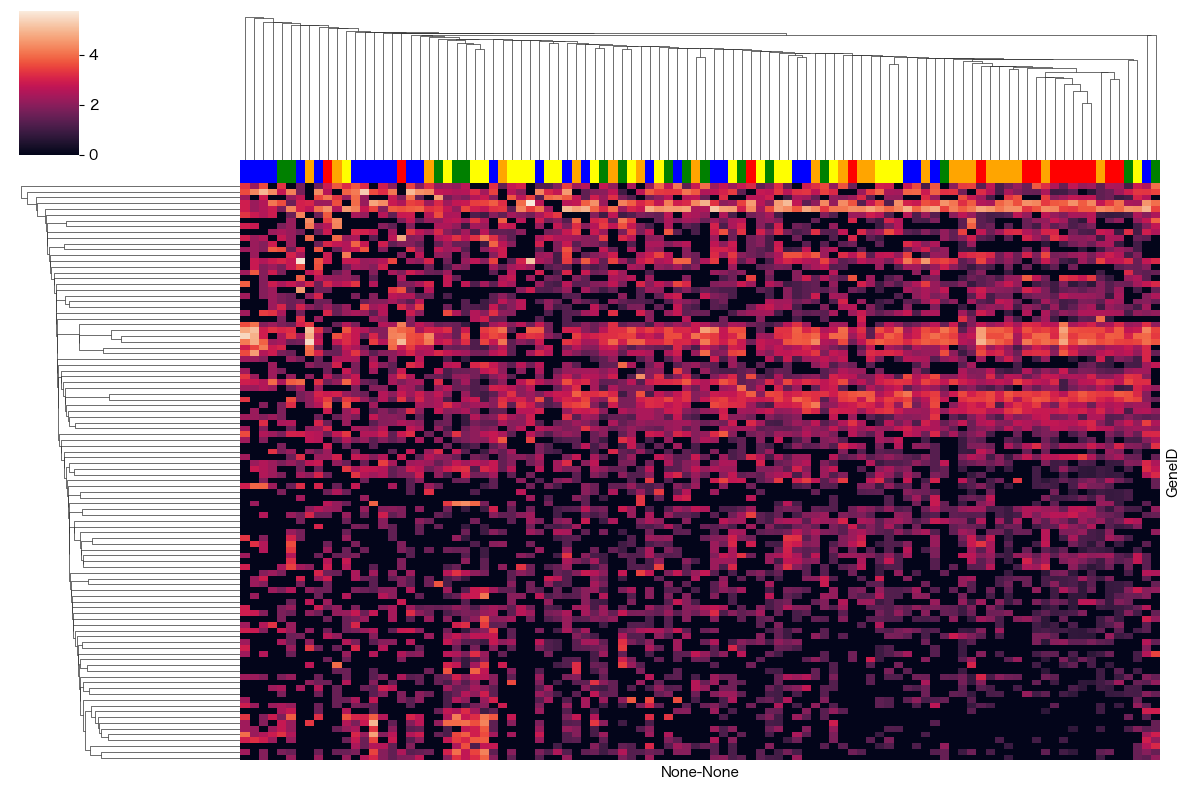

In [9]:
sns.clustermap(
    df_for_hclust,
    method = 'single',
    metric = 'euclidean',
    xticklabels = False,
    yticklabels = False,
    col_colors = cell_colors,
    figsize = (12, 8)
    
)

plt.show()

- 各行が遺伝子、各列が細胞、遺伝子発現量に応じて色が明るく表示される**ヒートマップ**、両方向の階層的クラスタリングを示すデンドログラムが描画できた
- 遺伝子に関しては、行方向にベクトルを取り出したときに類似したパターンの遺伝子がグルーピングされている
- 細胞に関しては、列方向にベクトルを取り出したときに類似したパターンの細胞がグルーピングされている
  - 特に、図中の赤色（Days0-3）に該当する細胞はよくまとまっている 
**鎖効果**（データ点が 1 つずつ順番にクラスターに取り込まれていく）が発生している。これは、single-linkage を使ったから

<span style="color: red">**課題 2：**</span> df_for_hclust に対して、sns の clustermap() メソッドを使って、ユークリッド距離、ウォード法でクラスタ分析した結果を表示して下さい。ただし、各細胞に対する色は label_to_colors を使うこととする。

/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


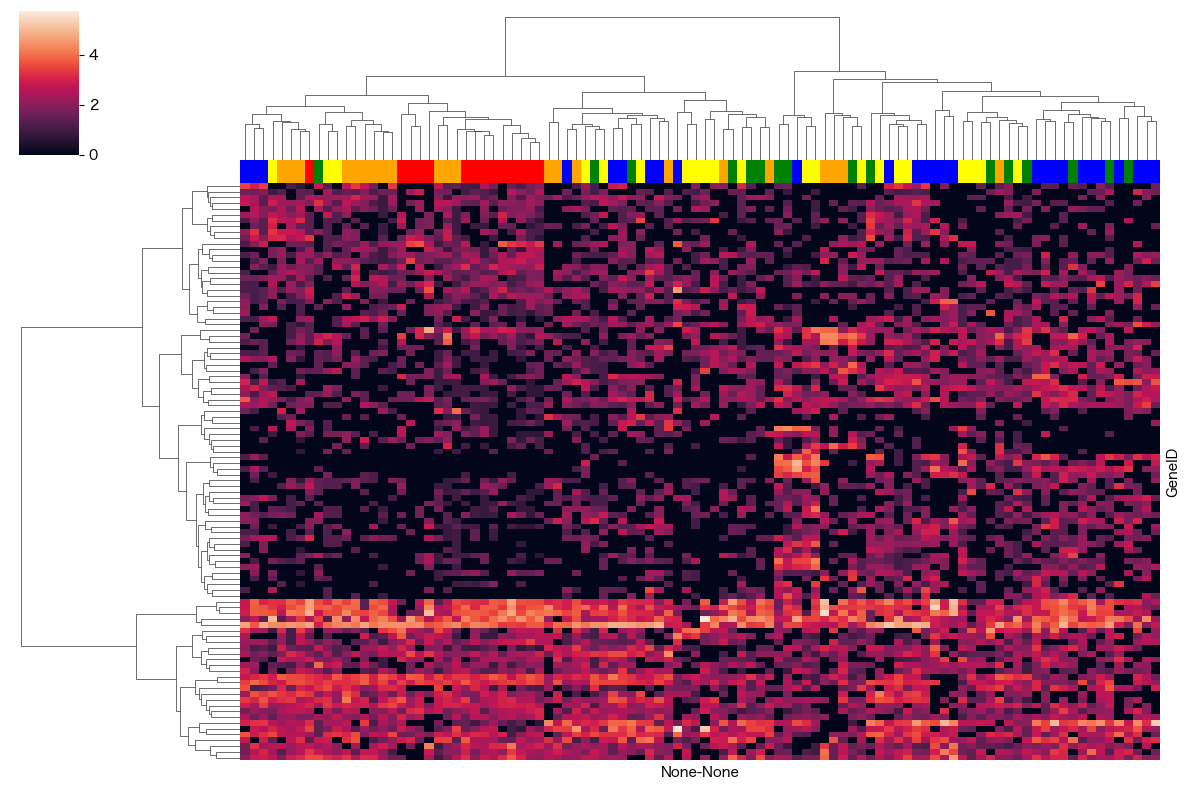

In [10]:
sns.clustermap(
    df_for_hclust,
    method = 'ward',
    metric = 'euclidean',
    xticklabels = False,
    yticklabels = False,
    col_colors = cell_colors,
    figsize = (12, 8)
    
)

plt.show()

- 鎖効果が解消され、細胞ごとのまとまり方がわかりやすくなった

#### 遺伝子名を表示してヒートマップのサイズも調整
- genes DataFrame を使って遺伝子の ID を遺伝子名に変換する

In [ ]:
# genes DataFrame から情報を抜き出して新しいカラムにセットする
df_for_hclust['Gene symbol'] = genes.loc[df_for_hclust.index, 'Symbol']

# 遺伝子名を新しいインデックスとしてセットする
df_for_hclust = df_for_hclust.set_index('Gene symbol')
display(df_for_hclust.iloc[:5, :5])
#df_for_hclust

<span style="color: red">**課題 3：**</span> df_for_hclust に対して、sns の clustermap() メソッドを使って、ユークリッド距離、ウォード法でクラスタ分析した結果を表示して下さい。ただし、各細胞に対する色は label_to_colors を使うこととする。また、sns の clustermap() の中で figsize を調整して納得がいくまで調整して下さい。

/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


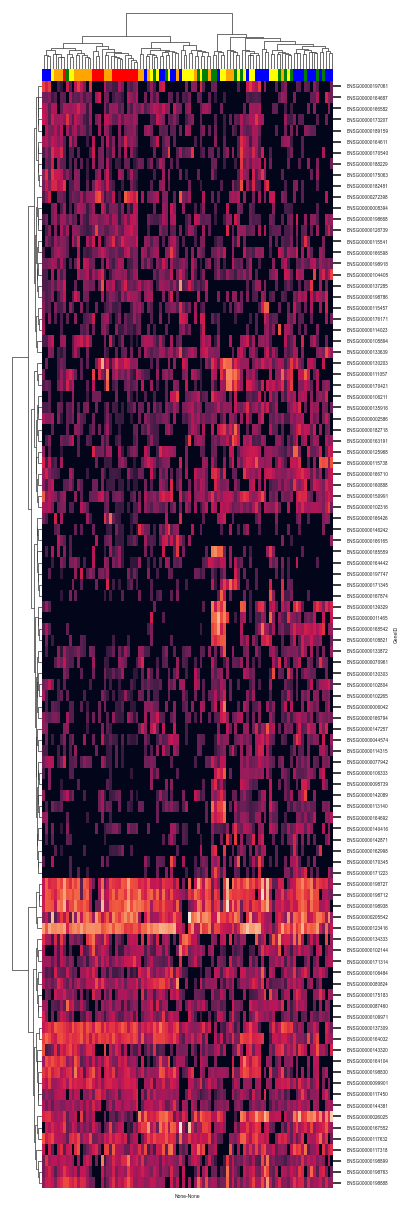

In [13]:
sns.set(font_scale=0.3)
sns.clustermap(
    df_for_hclust,
    method = 'ward',
    metric = 'euclidean',
    dendrogram_ratio = (0.1, 0.05),
    colors_ratio = 0.01,
    cbar_pos = None,
    xticklabels = False,
    col_colors = cell_colors,
    figsize = (4, 12)
    
)

plt.show()

- 階層的クラスタリングでは「この集団が 1 つのまとまり」といった明確なクラスタが得られない
- 階層的クラスタリングで個別のクラスタを得るには、デンドログラムをどこかの高さで切って、その断面を見る必要がある

---
---
### k-means クラスタリング（k 平均法）
- ユーザーが最初にクラスタの個数を指定して、データ点全体をその個数に（やや強引であっても）分割する
- この細胞が同じクラスタに属する、ということが明確に示される

#### 手順（下図の例）

- **step 1.** 入力データをプロットする。

- **step 2.** ランダムに 3 つの点（クラスターの**代表点**という）をプロットする。

- **step 3.** 各ランダム点を、クラスター 1、クラスター 2、クラスター 3 の重心点とラベリングする。。

- **step 4.** 入力データの各点について、3 つの重心点の中で最も近いものを選び、その番号を自身の所属スラスター番号とする。

- **step 5.** すべての入力データについてクラスター番号が決まった後、それぞれのクラスターの重心（平均）を計算する。

- **step 6.** step 5. で求めた 3 つの重心を新しいクラスターの重心点とする。

- **step 7.** step 4. から step 6. を繰り返す。ただし、繰り返し上限回数に達するか、または重心の移動距離が十分に小さくなったら終了とする。以下の**評価関数**が使われる（設定したクラスタの数 $K$、クラスタ $k$ に割り当てられたデータ点の集合 $C_k$、クラスタ $k$ の代表点のベクトルを $\mu_{\small k}$）

  $$
  \sum_{k=1}^K\sum_{x\in C_k}\|x-\mu_k\|^2
  $$

<img src="figs/k_means.jpg" width="500px">

- k-means のアルゴリズムは収束することが保証されているが、大域的最適解が得られるとは限らない
  - 代表点の**初期配置**に依存して結果が変わってしまう
- k-means++：できるだけ「よい」初期位置を見つけてクラスタリングするアルゴリズム

<span style="color: red">**課題 4：**</span> df_scaled.values.T に対して、クラスタの数を 2 個，初期配置を k-means++ としてクラスタ解析をし、それぞれのクラスタが含む細胞の個数を表示して下さい。

In [15]:
import sklearn.cluster

kmeans_model = sklearn.cluster.KMeans(n_clusters=2, init='k-means++', n_init='auto')

clusters = kmeans_model.fit_predict(df_scaled.values.T)

print(clusters)
print('cluster-0:', np.count_nonzero(clusters == 0))
print('cluster-1:', np.count_nonzero(clusters == 1))

[0 0 0 ... 1 1 1]
cluster-0: 2048
cluster-1: 1054


#### 結果を可視化するために UMAP で次元削減

In [16]:
import umap

umap_model = umap.UMAP(n_components=2,
                       n_neighbors=5, min_dist=0.01,
                       random_state=42, verbose=False)
umap_coords = umap_model.fit_transform(df_scaled.values.T)

/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/umap/utils.py:134: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit('i8(f8[:,:,:],i8,f8,i8,i8)')
/Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/umap/umap_.py:563: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(parallel=True)
/Users/shi

NumbaNotImplementedError: Failed in object mode pipeline (step: object mode frontend)
Failed in object mode pipeline (step: object mode backend)
<class 'numba.core.ir.DynamicRaise'>, <dynamic> raise <class 'ValueError'>(Var($binop_add1004.8, umap_.py:672))
During: lowering "<dynamic> raise <class 'ValueError'>(Var($binop_add1004.8, umap_.py:672))" at /Users/shishishikakou/Downloads/データサイエンス特論/.venv/lib/python3.11/site-packages/umap/umap_.py (672) 

This error may have been caused by the following argument(s):
- argument 2: Cannot determine Numba type of <class 'numpy.random.mtrand.RandomState'>
- argument 4: Cannot determine Numba type of <class 'dict'>


#### 結果を描画する関数の作成

In [17]:
sns.set(font_scale=1)

# クラスタの色として，matplotlibのtab20を使う
colors = [matplotlib.colors.to_hex(x) for x in matplotlib.cm.tab10.colors]

def plot_clusters(coords, clusters, ax):
    # それぞれのクラスタ（0, 1, ...）について
    for cluster_id in np.unique(clusters):
        # clustersが該当するクラスタIDの座標のみ取り出してプロット
        ax.scatter(coords[clusters == cluster_id, 0],
                   coords[clusters == cluster_id, 1],
                   s=6, alpha=0.5,
                   c=colors[cluster_id])
    for cluster_id in np.unique(clusters):
        # クラスタに所属する座標の平均を計算する
        centroid = np.mean(coords[clusters == cluster_id, :], axis=0)
        # クラスタIDのテキストを描画
        ax.annotate(str(cluster_id),
                    xy=(centroid), fontsize=13, color='white',
                    bbox={'facecolor':colors[cluster_id], 'edgecolor':'k', 'alpha':0.8})
    plt.axis('off')

#### 結果の描画
- 作成した plot_clusters() 関数を使って、UMAP 次元削減した座標で散布図を描く
- 細胞の色を、所属するクラスタで塗り分ける
- それぞれのクラスタに所属するデータの重心にクラスタのラベルを表示

NameError: name 'umap_coords' is not defined

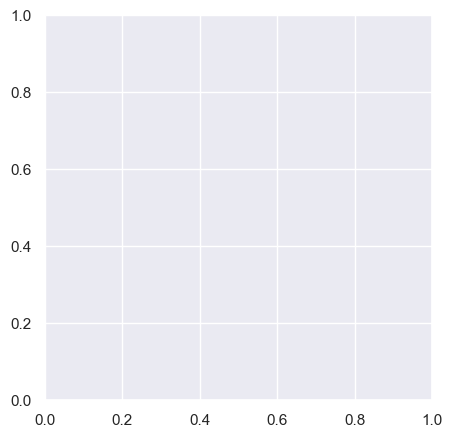

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_clusters(umap_coords, clusters, ax)
plt.show()

- 2 つのクラスタに所属するデータ点が中央付近でオーバーラップしている
- これは、UMAP 次元削減で高次元空間の情報が失われているため

#### クラスタ数を変えて実行

In [ ]:
fig = plt.figure(figsize=(12, 12))

for i, n_clusters in enumerate(range(2, 11)):
    print('Number of clusters:', n_clusters)
    kmeans_model = sklearn.cluster.KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init='auto'
    )
    
    clusters = kmeans_model.fit_predict(df_scaled.values.T)
    
    print('\t', ' '.join([str(cl) + ':' +
                          str(np.count_nonzero(clusters == cl))
                          for cl in np.unique(clusters)]))
    
    ax = fig.add_subplot(3, 3, i+1)
    plot_clusters(umap_coords, clusters, ax)
    ax.set_title('K = '+str(n_clusters))


plt.show()

#### k-means クラスタリングの問題点と対処
- クラスタリングを実行する前に、クラスタ数を手で与えなければいけない
  - 解決策：複数のクラスタ数で試して、何らかの基準でクラスタリング結果の「良さ」を比較
- 「良さ」をどうやって測る？
  - **シルエット係数**：同じクラスタに属するデータ間の距離は小さく、異なるクラスタに属するデータ間の距離は離れている
  - **エルボー法**：データ点ごとのクラスタ重心への距離の二乗和の総和の値が折れ曲がる所
  - **赤池情報量基準（AIC）**
  - **ベイズ情報量基準（BIC）**

In [ ]:
# エルボー法

dist_list=[]

for i, n_clusters in enumerate(range(2, 21)):
    #print('Number of clusters:', n_clusters)
    kmeans_model = sklearn.cluster.KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init='auto'
    ).fit(df_scaled.values.T)
    #clusters = kmeans_model.fit_predict(df_scaled.values.T)
    
    dist_list.append(kmeans_model.inertia_)

# グラフを表示
fig = plt.figure(figsize=(5,3))
plt.plot(range(2,21), dist_list, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
plt.close()

- 高次元で非線形性が強い生物学データでは、いずれの解決策を取ってもうまくいかない
- k-means クラスタリングは古典的で重要な方法だが、以下の問題点がある
  - 外れ値に弱い
  - クラスタサイズや密度がクラスタごとに大きく異なる場合に弱い
  - クラスタが球状に分布せず細長かったりする場合に弱い
- 近年のシングルセル解析では、高次元空間上に分布するデータ点の構成する「近傍グラフ構造」を利用したクラスタリングアルゴリズムがよく使われる